In [3]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import nltk
import spacy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.utils import to_categorical

In [7]:
# Vamos a utilizar NLTK para filtrar stopwords
nltk.download('punkt')
nltk.download('stopwords')

# Cargamos el modelo core de spacy
nlp = spacy.load('es_core_news_md')

[nltk_data] Downloading package punkt to /home/azureuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [115]:
# Definimos las categorías y frases para nuestro ChatBot
data = {
    "text": [
        "¿Cuál es tu nombre?", 
        "¿Cómo te llamas?", 
        "¿Cómo puedo llamarte?",
        "¿Cómo puedo decirte?",
        "¿A qué nombre respondes?",
        "Dime con cuál nombre te puedo llamar",
        "Quiero que me cuentes un chiste", 
        "Necestio reir, ¿me cuentas un chiste por favor?",
        "Dime algo gracioso", 
        "Contar chiste", 
        "Quiero que me digas algo chistoso para reir",
        "¿Qué chistes te sabes que me puedas decir?",
        "Quiero realizar una llamada",
        "Necesito hacer una llamada",
        "Llamar a una persona",
        "Quiero que me apoyes en realizar una llamada",
        "Llama a uno de mis contactos por favor",
        "Necesito hablarle con urgencia a uno de mis contactos",
        "¿Me ayudas a programar una alrma?",
        "Programa una alarma para las 8 AM",
        "Necesito levantarme temprano, programas mi alarma por favor?",
        "Programar alarma en la mañana para mi evento importante",
        "Ayuda con programación de alarma",
        "Me puedes despertar en la mañana por favor?"
    ],
    "category": ["nombre", "nombre", "nombre", "nombre", "nombre", "nombre",
                 "chiste", "chiste", "chiste", "chiste", "chiste", "chiste",
                 "llamar", "llamar", "llamar", "llamar", "llamar", "llamar",
                 "alarma", "alarma", "alarma", "alarma", "alarma", "alarma"]
}

df = pd.DataFrame(data)
df

text category
0                                 ¿Cuál es tu nombre?   nombre
1                                    ¿Cómo te llamas?   nombre
2                               ¿Cómo puedo llamarte?   nombre
3                                ¿Cómo puedo decirte?   nombre
4                            ¿A qué nombre respondes?   nombre
5                Dime con cuál nombre te puedo llamar   nombre
6                     Quiero que me cuentes un chiste   chiste
7     Necestio reir, ¿me cuentas un chiste por favor?   chiste
8                                  Dime algo gracioso   chiste
9                                       Contar chiste   chiste
10        Quiero que me digas algo chistoso para reir   chiste
11         ¿Qué chistes te sabes que me puedas decir?   chiste
12                        Quiero realizar una llamada   llamar
13                         Necesito hacer una llamada   llamar
14                               Llamar a una persona   llamar
15       Quiero que me apoyes en realizar una llamada   llamar
16             Llama a uno de mis contactos por favor   llamar
17  Necesito hablarle con urgencia a uno de mis co...   llamar
18                  ¿Me ayudas a programar una alrma?   alarma
19                  Programa una alarma para las 8 AM   alarma
20  Necesito levantarme temprano, programas mi ala...   alarma
21  Programar alarma en la mañana para mi evento i...   alarma
22                   Ayuda con programación de alarma   alarma
23        Me puedes despertar en la mañana por favor?   alarma

In [116]:
# Preprocesamos el text
def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

df['processed_text'] = df['text'].apply(preprocess_text)
df

text category  \
0                                 ¿Cuál es tu nombre?   nombre   
1                                    ¿Cómo te llamas?   nombre   
2                               ¿Cómo puedo llamarte?   nombre   
3                                ¿Cómo puedo decirte?   nombre   
4                            ¿A qué nombre respondes?   nombre   
5                Dime con cuál nombre te puedo llamar   nombre   
6                     Quiero que me cuentes un chiste   chiste   
7     Necestio reir, ¿me cuentas un chiste por favor?   chiste   
8                                  Dime algo gracioso   chiste   
9                                       Contar chiste   chiste   
10        Quiero que me digas algo chistoso para reir   chiste   
11         ¿Qué chistes te sabes que me puedas decir?   chiste   
12                        Quiero realizar una llamada   llamar   
13                         Necesito hacer una llamada   llamar   
14                               Llamar a una persona   llamar   
15       Quiero que me apoyes en realizar una llamada   llamar   
16             Llama a uno de mis contactos por favor   llamar   
17  Necesito hablarle con urgencia a uno de mis co...   llamar   
18                  ¿Me ayudas a programar una alrma?   alarma   
19                  Programa una alarma para las 8 AM   alarma   
20  Necesito levantarme temprano, programas mi ala...   alarma   
21  Programar alarma en la mañana para mi evento i...   alarma   
22                   Ayuda con programación de alarma   alarma   
23        Me puedes despertar en la mañana por favor?   alarma   

                                 processed_text  
0                                        nombre  
1                                        llamar  
2                                      llamarte  
3                                      decir tú  
4                              nombre respondes  
5                            dime nombre llamar  
6                           querer cuent chiste  
7             necestio reir contar chiste favor  
8                                 dime gracioso  
9                                 contar chiste  
10                   querer digar chistoso reir  
11                                chiste puedas  
12                               querer llamado  
13                            necesitar llamado  
14                               llamar persona  
15                        querer apoyes llamado  
16                        llamar contacto favor  
17        necesitar hablar él urgencia contacto  
18                        ayuda programar alrma  
19                           programa alarma am  
20  necesitar levantar yo programa alarma favor  
21    programar alarma mañana evento importante  
22                    ayuda programación alarma  
23                 poder despertar mañana favor

In [117]:
# Tokenizamos el texto
tokenizer = Tokenizer(num_words=500, split=' ')
tokenizer.fit_on_texts(df['processed_text'].values)
print(tokenizer.word_index)

{'llamar': 1, 'querer': 2, 'chiste': 3, 'favor': 4, 'alarma': 5, 'nombre': 6, 'llamado': 7, 'necesitar': 8, 'dime': 9, 'reir': 10, 'contar': 11, 'contacto': 12, 'ayuda': 13, 'programar': 14, 'programa': 15, 'mañana': 16, 'llamarte': 17, 'decir': 18, 'tú': 19, 'respondes': 20, 'cuent': 21, 'necestio': 22, 'gracioso': 23, 'digar': 24, 'chistoso': 25, 'puedas': 26, 'persona': 27, 'apoyes': 28, 'hablar': 29, 'él': 30, 'urgencia': 31, 'alrma': 32, 'am': 33, 'levantar': 34, 'yo': 35, 'evento': 36, 'importante': 37, 'programación': 38, 'poder': 39, 'despertar': 40}


In [118]:
X = tokenizer.texts_to_sequences(df['processed_text'].values)
X = pad_sequences(X, maxlen=5)
X

array([[ 0,  0,  0,  0,  6],
       [ 0,  0,  0,  0,  1],
       [ 0,  0,  0,  0, 17],
       [ 0,  0,  0, 18, 19],
       [ 0,  0,  0,  6, 20],
       [ 0,  0,  9,  6,  1],
       [ 0,  0,  2, 21,  3],
       [22, 10, 11,  3,  4],
       [ 0,  0,  0,  9, 23],
       [ 0,  0,  0, 11,  3],
       [ 0,  2, 24, 25, 10],
       [ 0,  0,  0,  3, 26],
       [ 0,  0,  0,  2,  7],
       [ 0,  0,  0,  8,  7],
       [ 0,  0,  0,  1, 27],
       [ 0,  0,  2, 28,  7],
       [ 0,  0,  1, 12,  4],
       [ 8, 29, 30, 31, 12],
       [ 0,  0, 13, 14, 32],
       [ 0,  0, 15,  5, 33],
       [34, 35, 15,  5,  4],
       [14,  5, 16, 36, 37],
       [ 0,  0, 13, 38,  5],
       [ 0, 39, 40, 16,  4]], dtype=int32)

In [122]:
# Creamos el encoder de los labels o salidas:
Y = pd.get_dummies(df['category']).values
Y

array([[False, False, False,  True],
       [False, False, False,  True],
       [False, False, False,  True],
       [False, False, False,  True],
       [False, False, False,  True],
       [False, False, False,  True],
       [False,  True, False, False],
       [False,  True, False, False],
       [False,  True, False, False],
       [False,  True, False, False],
       [False,  True, False, False],
       [False,  True, False, False],
       [False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False],
       [ True, False, False, False],
       [ True, False, False, False],
       [ True, False, False, False],
       [ True, False, False, False],
       [ True, False, False, False],
       [ True, False, False, False]])

In [123]:
# Dividimos la imformación en entrenamiento y validación (pruebas)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)

In [124]:
# Desactivar el uso de la GPU en TensorFlow
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Construimos el modelo
model = Sequential()
model.add(Embedding(41, 50, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [125]:
# Train the model
batch_size = 1
history = model.fit(X_train, Y_train, epochs=10, batch_size=batch_size, validation_data=(X_test, Y_test), verbose=2)

Epoch 1/10
21/21 - 2s - 80ms/step - accuracy: 0.1905 - loss: 1.3876 - val_accuracy: 0.3333 - val_loss: 1.3809
Epoch 2/10
21/21 - 0s - 3ms/step - accuracy: 0.6190 - loss: 1.3685 - val_accuracy: 0.3333 - val_loss: 1.3732
Epoch 3/10
21/21 - 0s - 3ms/step - accuracy: 0.6667 - loss: 1.3481 - val_accuracy: 0.3333 - val_loss: 1.3566
Epoch 4/10
21/21 - 0s - 3ms/step - accuracy: 0.7619 - loss: 1.3044 - val_accuracy: 0.3333 - val_loss: 1.3281
Epoch 5/10
21/21 - 0s - 3ms/step - accuracy: 0.8571 - loss: 1.2474 - val_accuracy: 0.3333 - val_loss: 1.3014
Epoch 6/10
21/21 - 0s - 3ms/step - accuracy: 0.8571 - loss: 1.1235 - val_accuracy: 0.3333 - val_loss: 1.2138
Epoch 7/10
21/21 - 0s - 3ms/step - accuracy: 0.8571 - loss: 0.9010 - val_accuracy: 0.3333 - val_loss: 1.1631
Epoch 8/10
21/21 - 0s - 3ms/step - accuracy: 0.8095 - loss: 0.7558 - val_accuracy: 0.3333 - val_loss: 1.2059
Epoch 9/10
21/21 - 0s - 3ms/step - accuracy: 0.9048 - loss: 0.5416 - val_accuracy: 0.3333 - val_loss: 1.1723
Epoch 10/10
21/21 

In [100]:
# Evaluamos el modelo
score, acc = model.evaluate(X_test, Y_test, verbose=2, batch_size=batch_size)
print("Accuracy: %.2f%%" % (acc * 100))

3/3 - 0s - 6ms/step - accuracy: 0.3333 - loss: 1.3057
Accuracy: 33.33%


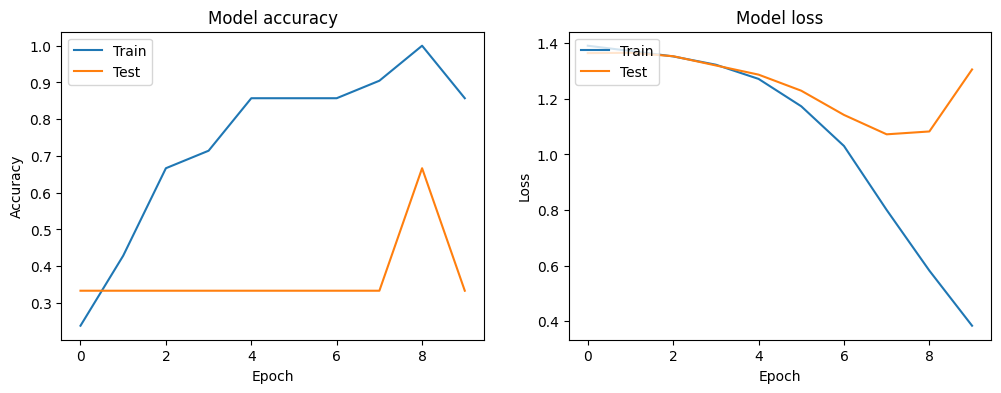

In [101]:
# Ploteamos la mejora en el entrenamiento y la validación para cada época
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Ploteamos la pérdida o el error para cada época
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [50]:
# Guardar el modelo y el tokenizador
import pickle

model.save('chatbot_model.h5')
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)